License and Car Detection Code
-------------------------------

This script is designed to detect cars and license plates in images using YOLOv8 and extract text from the detected license plates when a car is present.

1. It loads YOLOv8 model with pre-trained weights for object detection.
2. Loads a dataset from Roboflow for testing.
3. For each image in the dataset, it performs car and license plate detection.
4. If a car is detected in the image, it then extracts text from the detected license plates using Optical Character Recognition (OCR).
5. The results are saved or processed further as needed.

### Import Libraries

In [1]:
from ultralytics import YOLO
import cv2 as cv
from roboflow import Roboflow
from IPython.display import display, Image
from supervision.video.source import get_video_frames_generator
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.draw.color import ColorPalette
from supervision.video.dataclasses import VideoInfo
from supervision.video.sink import VideoSink
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import easyocr

### Load Models

In [2]:
model = YOLO('yolov8x.pt')
model.fuse() #model.summary 

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


### Select Some Classess

In [3]:
CLASS_ID = [2, 3, 5, 7]
class_names = model.model.names
class_names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

 ### Load Video

In [4]:
path = r"F:\computer vision\demo.mp4"
target_video_path = r"F:\computer vision\demo_target.mp4"

In [5]:
VideoInfo.from_video_path(path)

VideoInfo(width=1114, height=720, fps=30, total_frames=631)

#### Convert License image to Text by easyocr and use THRESH_BINARY_INV Opencv Filter

In [6]:
def convert_licence_to_text(licence_frame):
    global licences_text
    licences_text = []

    for licence in licence_frame.boxes.xyxy.cpu().numpy():

        x_min, y_min, x_max, y_max = licence
        license_plate_region = frame[int(y_min):int(y_max), int(x_min):int(x_max)]


        license_plate_crop_gray = cv.cvtColor(license_plate_region, cv.COLOR_BGR2GRAY)
        _, license_plate_crop_thresh = cv.threshold(license_plate_crop_gray, 95, 230, cv.THRESH_BINARY_INV)

        # Assuming you have the license_plate_region image
        text = reader.readtext(license_plate_crop_thresh)

        # Extract the recognized text
        recognized_text = text[0][1] if text else "No content license"
        print(recognized_text)
        licences_text.append(recognized_text)

### To write text on an image when you detect an object using YOLOv8 and supervision library

In [7]:
def annotator(results, frame, class_names, Licence=False):

    detections = Detections(
        xyxy=results.boxes.xyxy.cpu().numpy(),
        confidence=results.boxes.conf.cpu().numpy(),
        class_id=results.boxes.cls.cpu().numpy().astype(int)
    )
    # format custom labels
    if Licence:
        convert_licence_to_text(results)
        label = licences_text

    else:
        label = [
            f"{class_names[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
    # annotate and display frame
    frame = box_annotator.annotate(frame=frame, detections=detections, labels=label)

    return frame

In [8]:
best_Licence = YOLO(r"F:\computer vision\project\Licence\train3\weights\best.pt")

### Select English Language

In [9]:
reader = easyocr.Reader(['en'])  # You can specify the languages you want to support

CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


# Object Detection and Annotation

This code block processes video frames, performs object detection, and annotates frames with detected objects and license plates. It follows these steps:

1. Create a frame generator for video frames.
2. Create an instance of `BoxAnnotator` with specific settings for annotation.
3. Obtain video information from the provided video path.
4. Process the video frame by frame:
    - Perform object detection on each frame.
    - If multiple objects are detected, attempt to detect license plates.
    - Annotate the frame with detected objects and license plates.
    - Show and write the annotated frame to the output.

This code aims to enhance video frames with object and license plate annotations.



  0%|          | 0/631 [00:00<?, ?it/s]


0: 416x640 3 cars, 4030.3ms
Speed: 686.8ms preprocess, 4030.3ms inference, 1672.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 licences, 3561.7ms
Speed: 0.0ms preprocess, 3561.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


R-183-JF
No content license


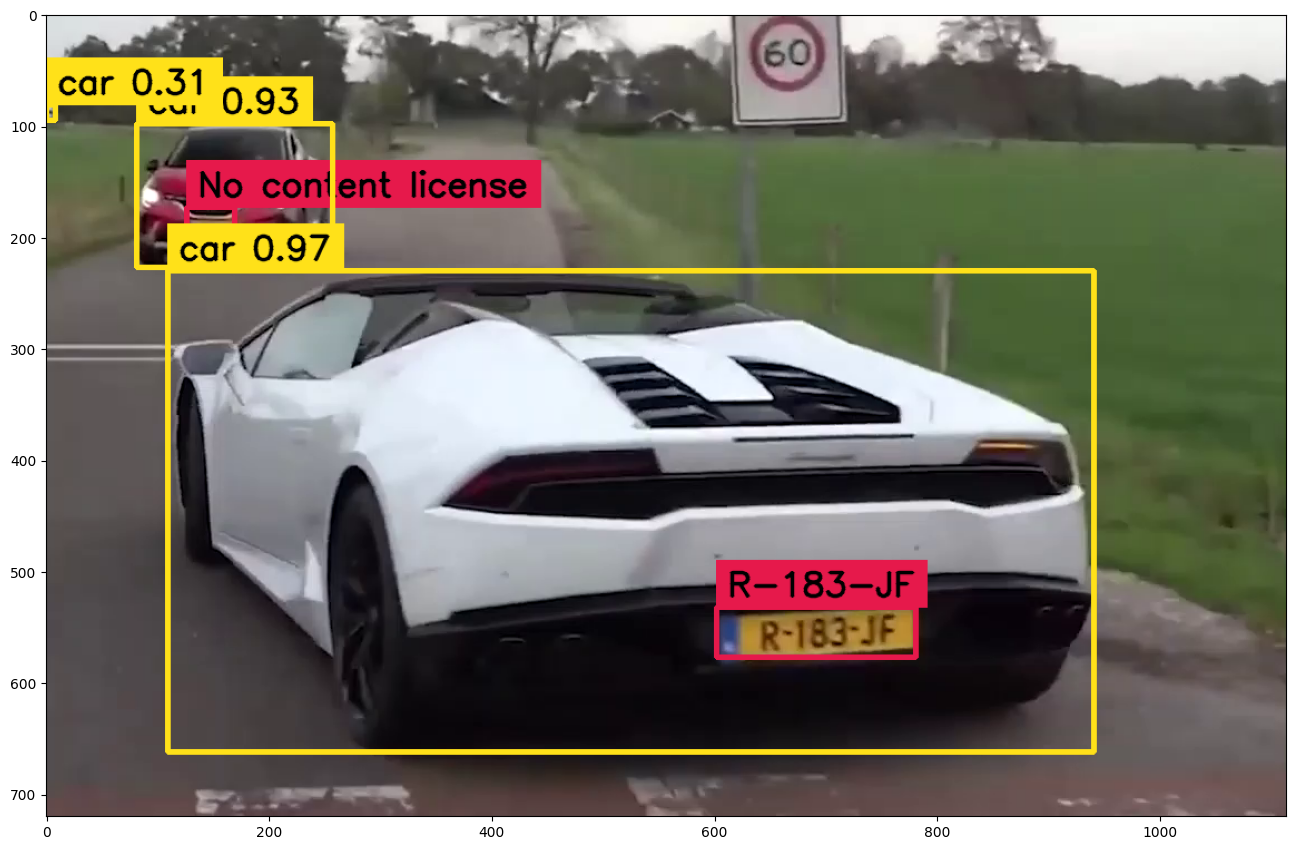


0: 416x640 3 cars, 3057.0ms
Speed: 0.0ms preprocess, 3057.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 licences, 3557.3ms
Speed: 15.6ms preprocess, 3557.3ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


R-783-JF
No content license


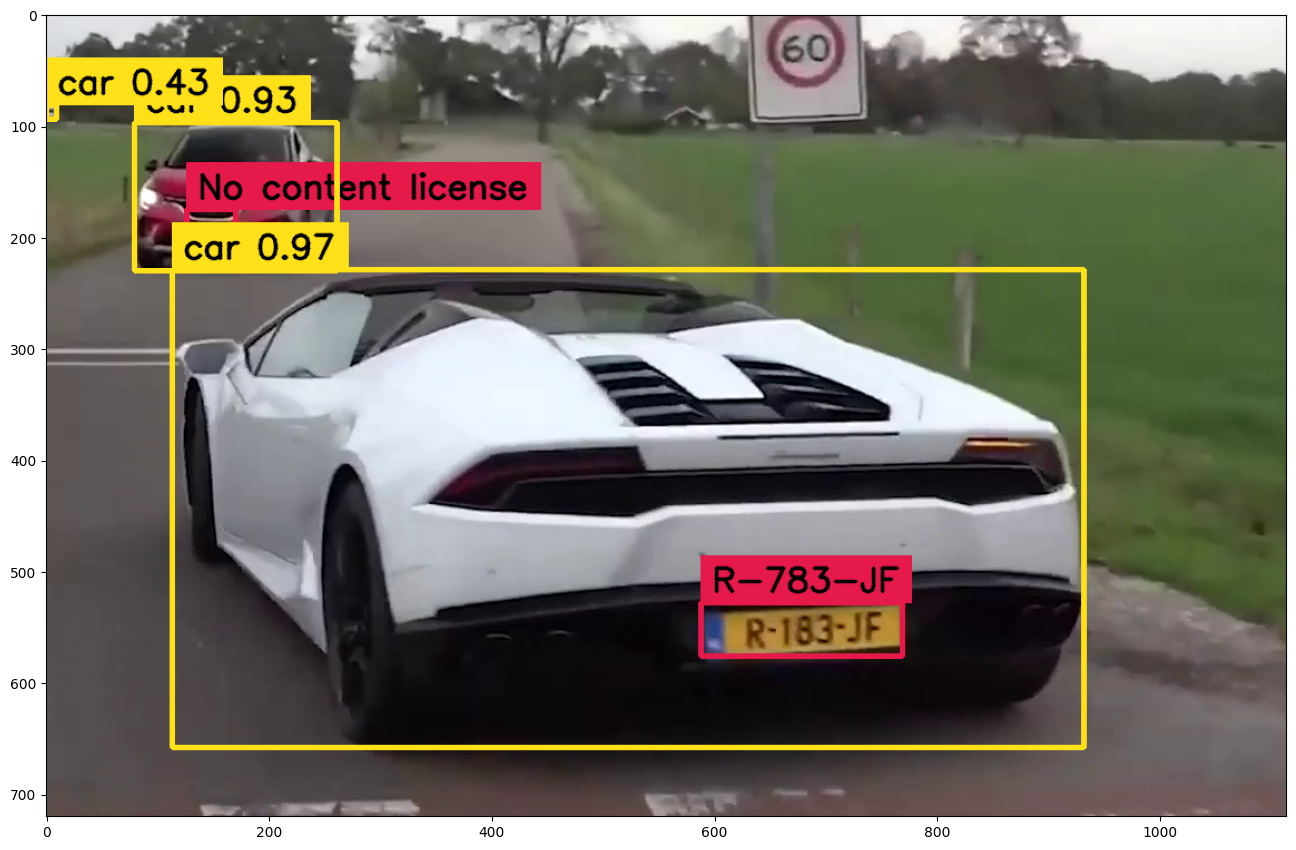


0: 416x640 3 cars, 3243.8ms
Speed: 0.0ms preprocess, 3243.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 licences, 4164.8ms
Speed: 15.6ms preprocess, 4164.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


R-183-JF
No content license


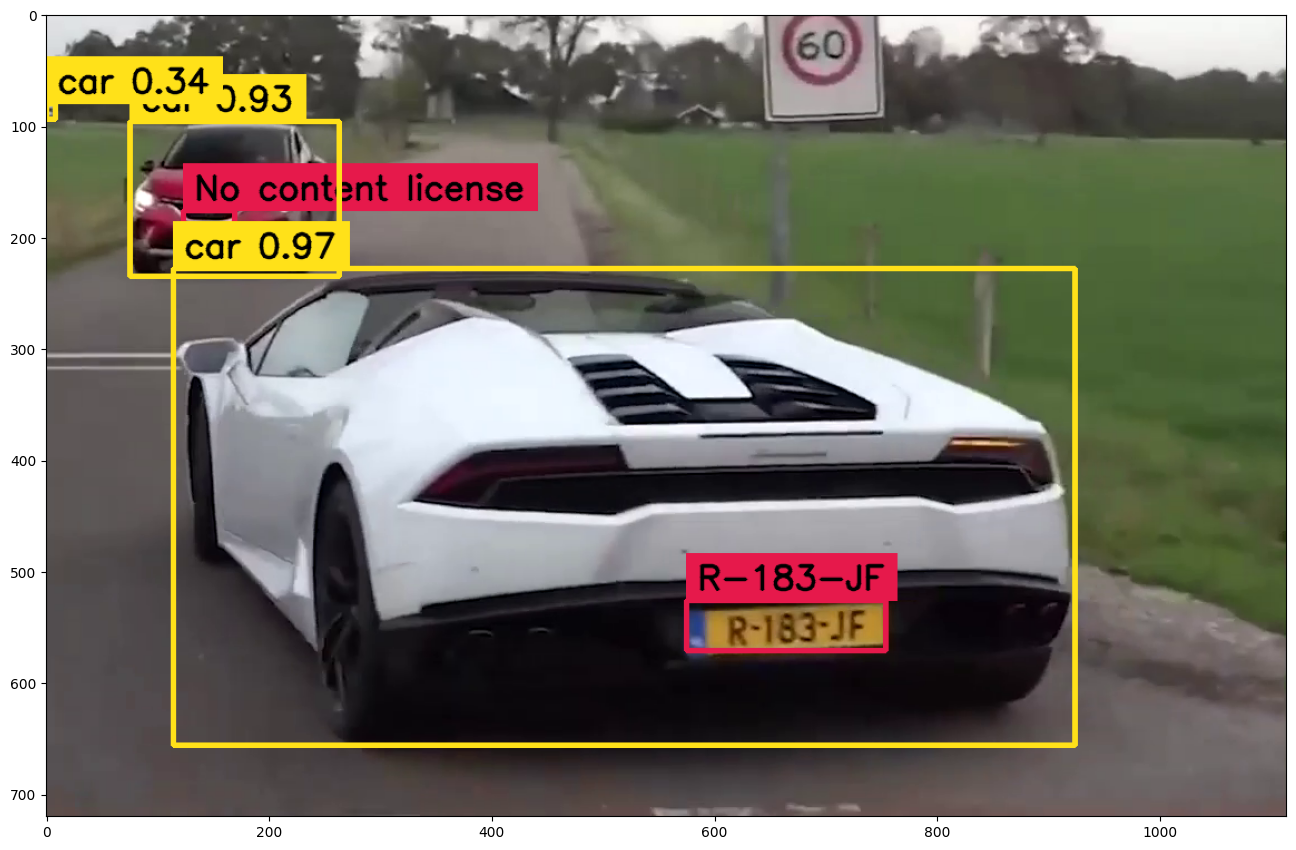


0: 416x640 2 cars, 3352.1ms
Speed: 2.1ms preprocess, 3352.1ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 licences, 3420.5ms
Speed: 9.0ms preprocess, 3420.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


R.183 JF
No content license


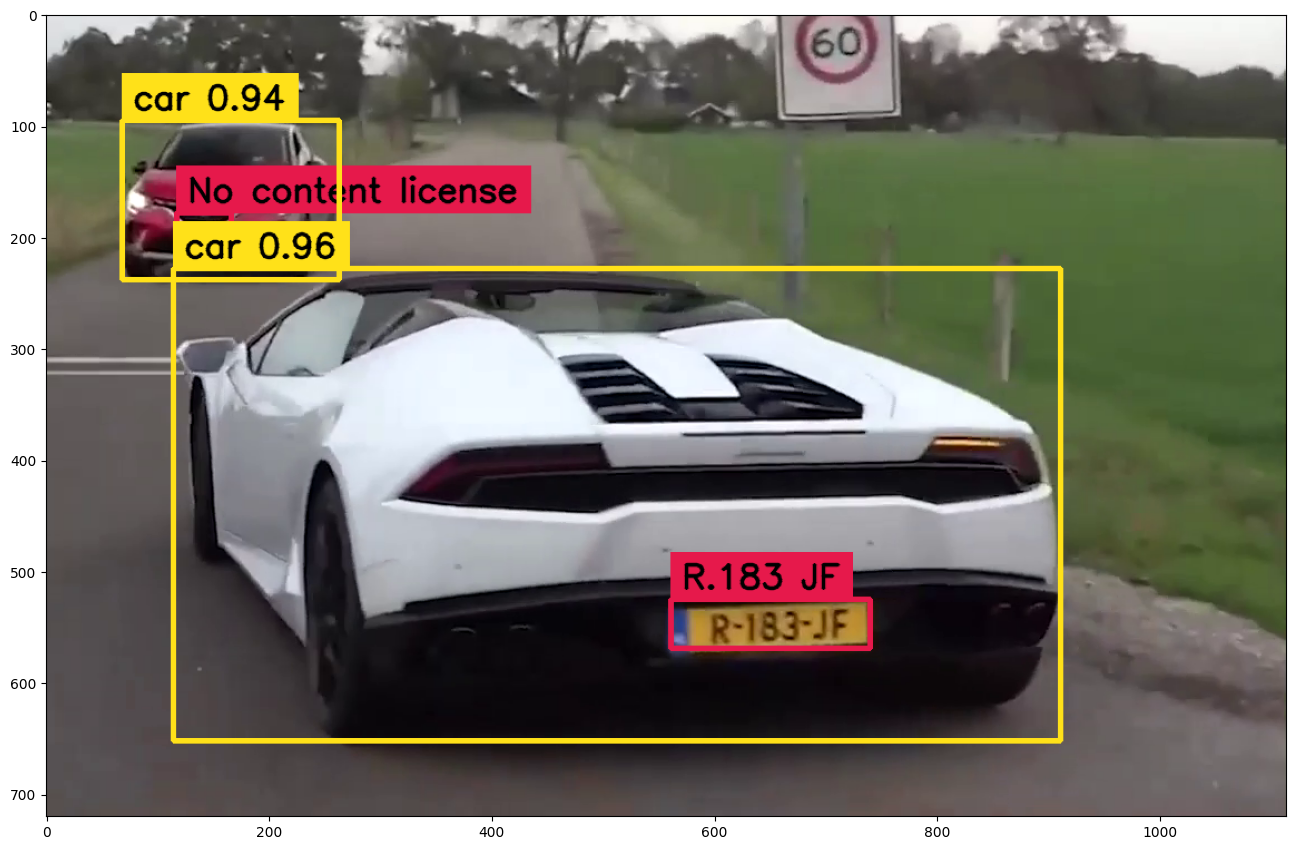


0: 416x640 2 cars, 3171.0ms
Speed: 4.6ms preprocess, 3171.0ms inference, 26.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 licences, 3568.4ms
Speed: 16.3ms preprocess, 3568.4ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


R-183-Jf
No content license


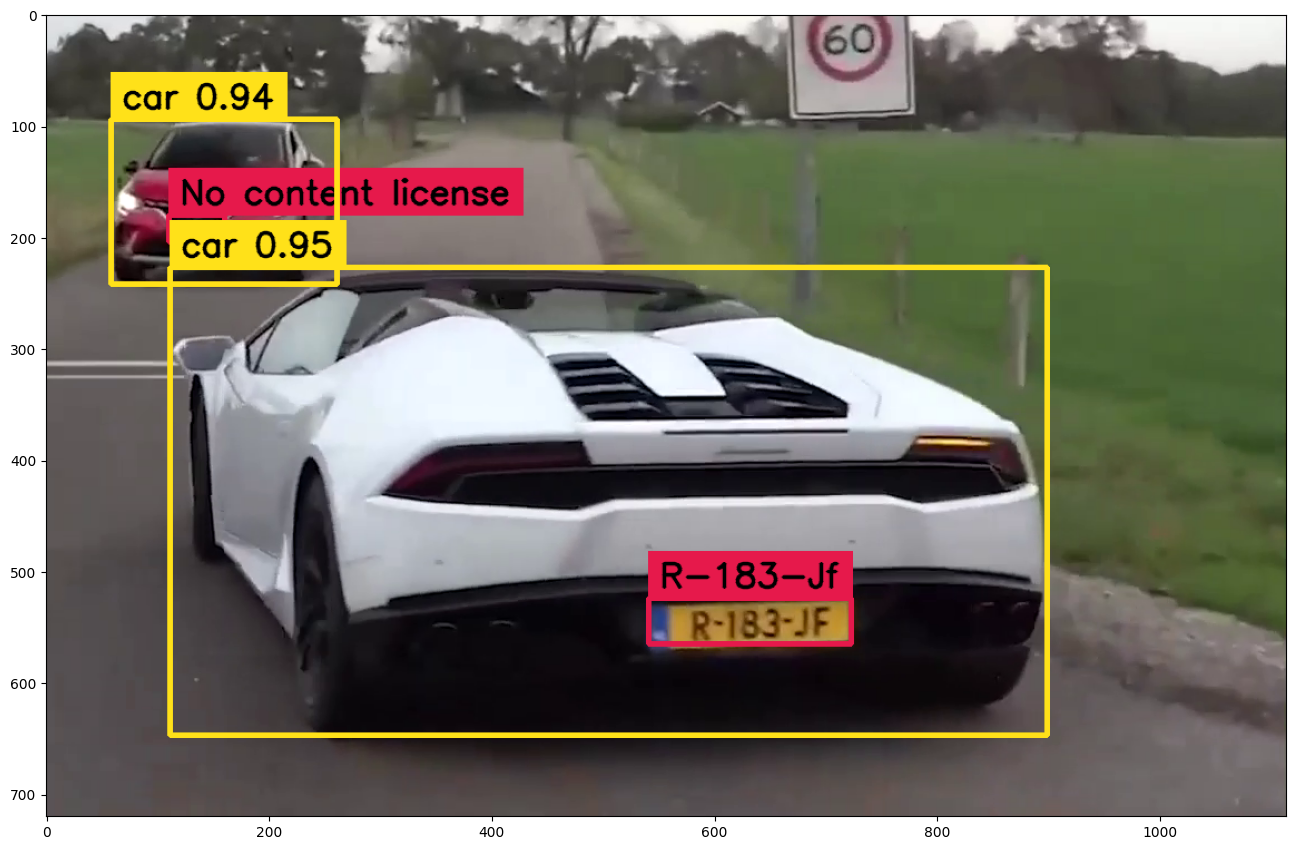


0: 416x640 2 cars, 3251.5ms
Speed: 15.6ms preprocess, 3251.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 licences, 3815.7ms
Speed: 14.6ms preprocess, 3815.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


R-183-JF=
No content license
No content license


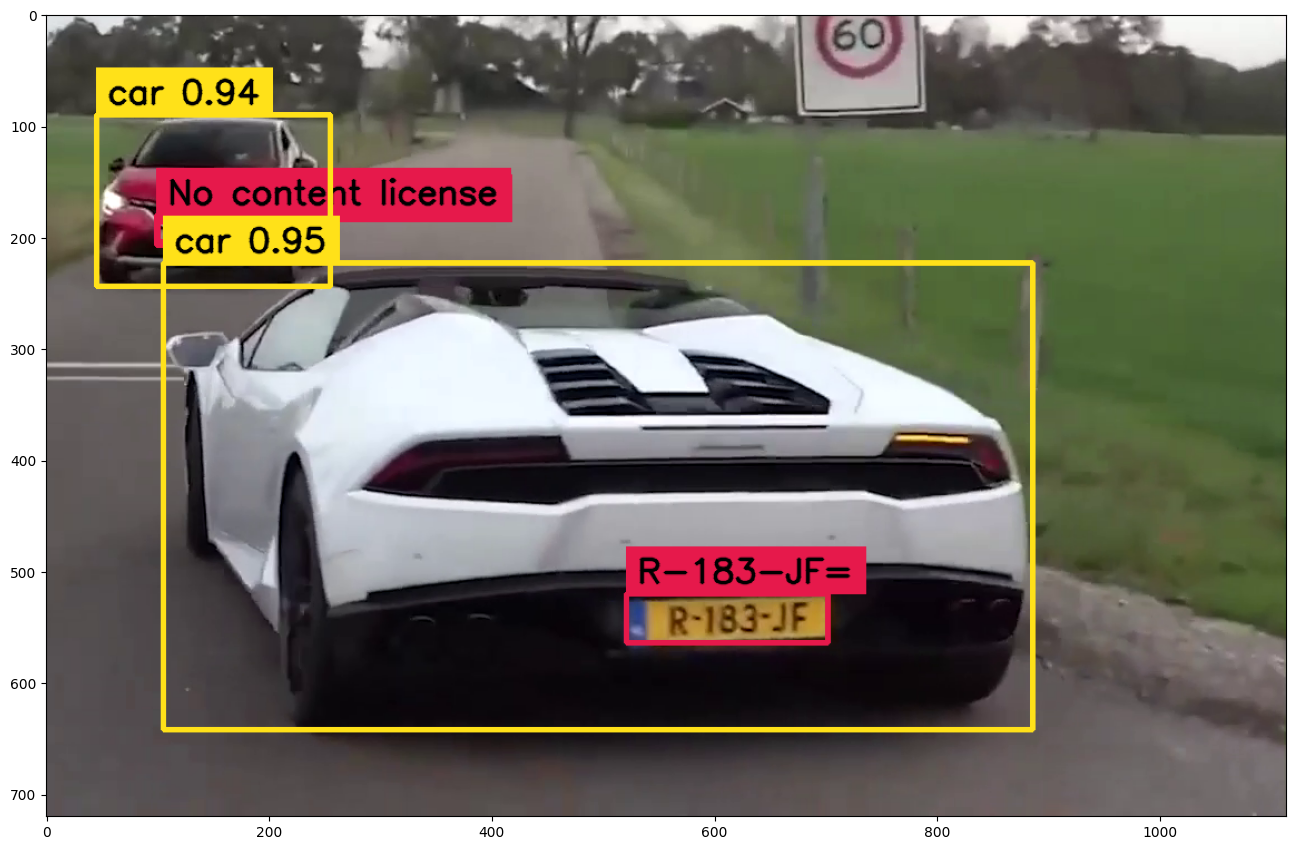



KeyboardInterrupt



In [10]:
# create frame generator
generator = get_video_frames_generator(path)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=3, text_thickness=2, text_scale=1)
video_info = VideoInfo.from_video_path(path)
# acquire first video frame

with VideoSink(target_video_path, video_info) as sink:

    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        if len(results[0].boxes.xyxy.cpu().numpy()) > 1:
            licence_frame = best_Licence(frame)
            frame = annotator(licence_frame[0], frame, best_Licence.model.names, Licence=True)


            frame = annotator(results[0], frame, class_names)

        %matplotlib inline
        sink.write_frame(frame)
        show_frame_in_notebook(frame, (16, 16))